### Imports

In [60]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import scipy.sparse as sp
import pandas as pd
import matplotlib.pyplot as plt
import math 
import os 

### Visualization Functions

In [61]:
# Function to save SIRV proportions
def save_and_plot_sirv_proportions(S, I, R, V, population, counties, time_periods, output_folder):
    # Load county names
    county_names_path = os.path.join("inputData", "floridaCountyNames.csv")
    county_names_df = pd.read_csv(county_names_path)
    county_names = county_names_df["County"].tolist()

    # Collect SIRV proportions data
    sirv_data = []
    for i in counties:
        for t in time_periods:
            total_population = population[i]
            s_prop = S[i, t].x / total_population if total_population > 0 else 0
            i_prop = I[i, t].x / total_population if total_population > 0 else 0
            r_prop = R[i, t].x / total_population if total_population > 0 else 0
            v_prop = V[i, t].x / total_population if total_population > 0 else 0
            sirv_data.append([i, t, s_prop, i_prop, r_prop, v_prop])
    
    sirv_df = pd.DataFrame(sirv_data, columns=["region", "timePeriod", "S_proportion", "I_proportion", "R_proportion", "V_proportion"])
    sirv_csv_path = os.path.join(output_folder, "sirvProportions.csv")
    sirv_df.to_csv(sirv_csv_path, index=False)
    print(f"SIRV proportions data saved to '{sirv_csv_path}'")

    # Plot SIRV proportions
    num_regions = len(counties)
    rows = min(23, num_regions)
    cols = math.ceil(num_regions / rows)

    fig, axes = plt.subplots(rows, cols, figsize=(15, 60), sharex=True, sharey=True)
    fig.suptitle("SIRV Proportions Over Time for Each County", fontsize=16, y=0.95)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])

    for idx, i in enumerate(counties):
        row = idx // cols
        col = idx % cols
        ax = axes[row, col] if rows > 1 else axes[col]
        
        region_data = sirv_df[sirv_df["region"] == i]
        county_name = county_names[i - 1] if i - 1 < len(county_names) else f"Region {i}"
        ax.plot(region_data["timePeriod"], region_data["S_proportion"], label="S", color="blue")
        ax.plot(region_data["timePeriod"], region_data["I_proportion"], label="I", color="red")
        ax.plot(region_data["timePeriod"], region_data["R_proportion"], label="R", color="green")
        ax.plot(region_data["timePeriod"], region_data["V_proportion"], label="V", color="orange")
        ax.legend(loc="upper right", fontsize=6)
        ax.set_title(county_name, fontsize=10)
        ax.grid(False)
        
        if row == rows - 1:
            ax.set_xlabel("Time Period")
        if col == 0:
            ax.set_ylabel("Proportion")

    plot_path = os.path.join(output_folder, "sirvProportions.png")
    plt.savefig(plot_path, bbox_inches='tight')
    print(f"SIRV proportions plot saved to '{plot_path}'")
    plt.show()


# Function to save decision variables to CSV files
def save_decision_variables(Z, A, S, I, R, V, U, output_folder, time_periods, decision_periods, counties):
    os.makedirs(output_folder, exist_ok=True)

    # Save patient transfer data based on binary variable A
    transfer_data = []
    for i in counties:
        for j in counties:
            for t in decision_periods:
                if A[i, j, t].x > 0.5:  # Check if A[i, j, t] is active (binary decision variable)
                    transfer_data.append([i, j, t, int(A[i, j, t].x)])
    transfer_csv_path = os.path.join(output_folder, "transferData.csv")
    transfer_df = pd.DataFrame(transfer_data, columns=["fromRegion", "toRegion", "timePeriod", "transferIndicator"])
    transfer_df.to_csv(transfer_csv_path, index=False)
    print(f"Patient transfer data saved to '{transfer_csv_path}'")

    # Save actual patient movement quantities in Z
    travel_data = []
    for i in counties:
        for j in counties:
            for t in decision_periods:
                quantity = Z[i, j, t].x
                if quantity > 0:
                    travel_data.append([i, j, t, quantity])
    travel_csv_path = os.path.join(output_folder, "travelData.csv")
    travel_df = pd.DataFrame(travel_data, columns=["fromRegion", "toFacility", "timePeriod", "quantity"])
    travel_df.to_csv(travel_csv_path, index=False)
    print(f"Travel data saved to '{travel_csv_path}'")

    # Save vaccine administration data
    vaccine_admin_data = []
    for i in counties:
        for t in time_periods:
            quantity = V[i, t].x
            if quantity > 0:
                vaccine_admin_data.append([i, t, quantity])
    vaccine_admin_csv_path = os.path.join(output_folder, "vaccineAdminData.csv")
    vaccine_admin_df = pd.DataFrame(vaccine_admin_data, columns=["region", "timePeriod", "administeredVaccines"])
    vaccine_admin_df.to_csv(vaccine_admin_csv_path, index=False)
    print(f"Vaccine administration data saved to '{vaccine_admin_csv_path}'")

    # Save SIRV data
    save_variable_to_csv(S, "S", "susceptibleData.csv", output_folder, counties, time_periods)
    save_variable_to_csv(I, "I", "infectedData.csv", output_folder, counties, time_periods)
    save_variable_to_csv(R, "R", "recoveredData.csv", output_folder, counties, time_periods)
    save_variable_to_csv(V, "V", "vaccinatedData.csv", output_folder, counties, time_periods)
    save_variable_to_csv(U, "U", "unmetDemandData.csv", output_folder, counties, decision_periods)


# Helper function to save each variable to CSV
def save_variable_to_csv(var, var_name, file_name, output_folder, counties, time_periods):
    data = []
    for i in counties:
        for t in time_periods:
            data.append([i, t, var[i, t].x])
    df = pd.DataFrame(data, columns=["region", "timePeriod", var_name])
    path = os.path.join(output_folder, file_name)
    df.to_csv(path, index=False)
    print(f"{var_name} data saved to '{path}'")


# Function to plot unmet demand
import matplotlib.pyplot as plt

def plot_unmet_demand(U, decision_periods, counties):
    unmet_demand = []
    
    for t in decision_periods:
        total_demand = sum(U.get((i, t), 0).x if (i, t) in U else 0 for i in counties)
        unmet_demand.append(total_demand)
    
    print(unmet_demand)
    
    plt.figure(figsize=(10, 6))
    plt.plot(decision_periods, unmet_demand, marker='o', linestyle='-', color='b')
    plt.title("Total Unmet Healthcare Demand Over Time")
    plt.xlabel("Time Period (days)")
    plt.ylabel("Total Unmet Demand (individuals)")
    plt.grid(True)
    #plt.yscale('log')
    plt.xticks(decision_periods)
    plt.show()



# Run the Model

### Load Data / Parameters and Variables

In [62]:
# Loading Data
alphaDF = pd.read_excel("inputData\\alpha_global_95_modified.xlsx", header = None)
betaDF = pd.read_excel("inputData\\mean_beta_modified.xlsx", header = None)
gammaDF = pd.read_excel("inputData\\mean_gamma_modified.xlsx", header = None)
distanceDF = pd.read_excel("inputData\\ordered_distance_modified.xlsx", header = None)
capacityDF = pd.read_excel("inputData\\capacity_modified.xlsx", header = None)
populationDF = pd.read_excel("inputData\\pop_modified.xlsx", header = None)
susceptibleDF = pd.read_excel("inputData\\S_modified.xlsx", header = None)
infectedDF = pd.read_excel("inputData\\I_modified.xlsx", header = None)
recoveredDF = pd.read_excel("inputData\\R_modified.xlsx", header = None)

# Sets
iSet = range(1, 68) # counties
jSet = range(1, 68) # counties
kSet = range(10, 160, 10) # decision frequency 
tSet = range(1, 156) # time period

# Model Parameters
alpha = {(i,t): alphaDF.iloc[i-1][t-1] for i in iSet for t in tSet} 
beta = {i: betaDF.iloc[i - 1, 0] for i in iSet} # infection rate
#beta = {i: 0.99 for i in iSet} # infection rate
gamma = {i: gammaDF.iloc[i - 1, 0] for i in iSet} # recovery rate
#gamma = {i: 0 for i in iSet}
d = {(i, j): distanceDF.iloc[i-1, j-1] for i in iSet for j in jSet} # distance matrix
cap = {i: capacityDF.iloc[i - 1, 0] for i in iSet} # hospital capacity
#cap = {i: 0 for i in iSet} # hospital capacity
N = {i: populationDF.iloc[i - 1, 0] for i in iSet} # county population
initS = {i: susceptibleDF.iloc[i - 1, 0] for i in iSet} 
initI = {i: infectedDF.iloc[i - 1, 0] for i in iSet} 
initR = {i: recoveredDF.iloc[i - 1, 0] for i in iSet} 

tMax = 155
bigM = 1e6
pandemicSize = 1
totalPopulation = 18379601
uCost = 3
dMax = 70 # maximum allowable travel distance
q = 10 # decision interval for 


lambdaa = 0.1 # vaccination rate
#lambdaa = 0 # vaccination rate
#qq = 0 # immunity loss rate
qq = 0.05 # immunity loss rate
omega = 0.11 # vaccine based immunity loss rate 
ell = 0.3 # vaccine inefficacy rate 

# Initialize Gurobi model
model = gp.Model("SIRV_Model")

########### Decision Variables ##########
# Nonnegative Decision Variables
S = model.addVars(iSet, tSet, lb=0, vtype=GRB.CONTINUOUS, name="S") # susceptible individuals    
I = model.addVars(iSet, tSet, lb=0, vtype=GRB.CONTINUOUS, name="I") # infected individuals   
R = model.addVars(iSet, tSet, lb=0, vtype=GRB.CONTINUOUS, name="R")  # recovered individuals     
V = model.addVars(iSet, tSet, lb=0, vtype=GRB.CONTINUOUS, name="V") # vaccinated individuals  
Z = model.addVars(iSet, jSet, kSet, lb=0, vtype=GRB.CONTINUOUS, name="Z") # number of transfers          
U = model.addVars(iSet, kSet, lb=0, vtype=GRB.CONTINUOUS,name="U") # unmet demand   
phi = model.addVars(iSet, kSet, lb=0, vtype=GRB.CONTINUOUS, name="phi") # unmet demand   
 
#totalUnmetCost = model.addVars(iSet, kSet, lb=0, name="TUC") # total unmet cost
#totalDistanceTraveled = model.addVars(iSet, jSet, kSet, lb=0, name="TDT") # total distance traveled
#objective = model.addVars(iSet, jSet, kSet, lb=0, name="objective") # objective value
#numTransfered = model.addVars(iSet, jSet, kSet, lb=0, name="NT") # number of transfered 

# Binary Decision Variables   
A = model.addVars(iSet, jSet, kSet, vtype=GRB.BINARY, name="A") # binary travel variable

# Linearization Variables
#zz = model.addVars(iSet, kSet, lb=0, name="zz") # objective 
Y = model.addVars(iSet, tSet, lb=0, vtype=GRB.CONTINUOUS, name="Y") # linearization constraint for SI
W = model.addVars(iSet, tSet, lb=0, vtype=GRB.CONTINUOUS, name="W") # linearization constraint

### Model Code

In [ ]:
# Objective
model.setObjective(gp.quicksum(U[i,k] for i in iSet for k in kSet), GRB.MINIMIZE)
#model.setParam(gp.GRB.Param.DisplayInterval, 10)  # Show progress every 1 second
#model.setParam(gp.GRB.Param.NumericFocus, 3)  # Improve numerical stability
#model.setParam(gp.GRB.Param.FeasibilityTol, 1e-9)  # Tighter feasibility tolerance
#model.setParam(gp.GRB.Param.OptimalityTol, 1e-9)  # Improve optimality precision

# Constraints
for i in iSet:
    for t in tSet:
        if t == 1:
            model.addConstr(S[i, t] == initS[i])
            model.addConstr(I[i, t] == initI[i])
            model.addConstr(R[i, t] == initR[i])
            model.addConstr(V[i, t] == 0)
        else:
            model.addConstr(S[i, t] == S[i, t-1] - beta[i]*Y[i,t-1]/N[i] - lambdaa*S[i, t-1] + omega*V[i,t-1] + qq*R[i,t-1])
            if t % q == 0:
                model.addConstr(I[i,t] == I[i, t-1] + beta[i]*Y[i, t-1]/N[i] + beta[i]*ell*W[i, t-1] / N[i] - gamma[i]*I[i, t-1] + gp.quicksum(Z[j,i,t] - Z[i,j,t] for j in jSet if i != j))
            else:
                model.addConstr(I[i,t] == I[i, t-1] + beta[i]*Y[i, t-1]/N[i] + beta[i]*ell*W[i, t-1] / N[i] - gamma[i]*I[i, t-1])
            model.addConstr(R[i,t] == R[i, t-1]  + gamma[i]*I[i, t-1] - qq*R[i, t-1])
            model.addConstr(V[i, t] == V[i, t-1] + lambdaa*S[i, t-1] - omega*V[i, t-1] - beta[i]*ell*W[i, t-1]/N[i])

# Travel Constraints
for i in iSet:
    for j in iSet:
        for k in kSet:
            model.addConstr(Z[i,j,k] <= bigM * A[i,j,k])
            model.addConstr(A[i,j,k] * d[i,j] <= dMax)
            model.addConstr(Z[i,j,k] >= A[i,j,k])

# Linearization Constraints
for i in iSet:
    for t in tSet:
        model.addConstr(Y[i, t] >= 0)
        model.addConstr(Y[i, t] >= N[i] * I[i, t] + N[i] * S[i, t] - N[i] ** 2)
        model.addConstr(Y[i, t] <= N[i] * S[i, t])
        model.addConstr(Y[i, t] <= N[i] * I[i, t])
        model.addConstr(W[i, t] >= 0)
        model.addConstr(W[i, t] >= N[i] * V[i, t] + N[i] * I[i, t]  - N[i] ** 2)
        model.addConstr(W[i, t] <= N[i] * V[i, t])
        model.addConstr(W[i, t] <= N[i] * I[i, t])   

# Unmet and Satisfied Demand            
for i in iSet:
    for k in kSet:
        tLo = max(k - q + 1, 1)  # avoid negative or zero
        demand_expr = gp.quicksum(alpha[i,t] * I[i,t] for t in range(tLo, k+1))
        net_flow_expr = gp.quicksum(Z[j,i,k] - Z[i,j,k] for j in jSet if j != i)

        # phi(i,k) + U(i,k) = demand + net inflow
        model.addConstr(U[i,k] == demand_expr + net_flow_expr - phi[i,k])

        # phi(i,k) <= cap(i)*gamma(i)
        model.addConstr(phi[i,k] <= cap[i] * gamma[i])

        
# Optimize the model
model.optimize()  
print(f"Final Objective Value: {model.ObjVal:.6f}")


Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11+.0 (26100.2))

CPU model: Intel(R) Core(TM) Ultra 9 185H, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 22 logical processors, using up to 22 threads

Optimize a model with 328635 rows, 198990 columns and 945571 nonzeros
Model fingerprint: 0x4c8fb9e4
Variable types: 131655 continuous, 67335 integer (67335 binary)
Coefficient statistics:
  Matrix range     [3e-08, 2e+06]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+00, 6e+12]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 26462 rows and 67 columns
Presolve time: 0.05s

Explored 0 nodes (0 simplex iterations) in 0.11 seconds (0.18 work units)
Thread count was 1 (of 22 available processors)

Solution count 0

Model is infeasible
Best objective -, best bound -, gap -


AttributeError: Unable to retrieve attribute 'ObjVal'

### Saving and Visualization

{(1, 10): <gurobi.Var U[1,10] (value 0.0)>, (1, 20): <gurobi.Var U[1,20] (value 0.0)>, (1, 30): <gurobi.Var U[1,30] (value 0.0)>, (1, 40): <gurobi.Var U[1,40] (value 0.0)>, (1, 50): <gurobi.Var U[1,50] (value 0.0)>, (1, 60): <gurobi.Var U[1,60] (value 0.0)>, (1, 70): <gurobi.Var U[1,70] (value 0.0)>, (1, 80): <gurobi.Var U[1,80] (value 0.0)>, (1, 90): <gurobi.Var U[1,90] (value 0.0)>, (1, 100): <gurobi.Var U[1,100] (value 0.0)>, (1, 110): <gurobi.Var U[1,110] (value 0.0)>, (1, 120): <gurobi.Var U[1,120] (value 0.0)>, (1, 130): <gurobi.Var U[1,130] (value 0.0)>, (1, 140): <gurobi.Var U[1,140] (value 0.0)>, (1, 150): <gurobi.Var U[1,150] (value 0.0)>, (2, 10): <gurobi.Var U[2,10] (value 0.0)>, (2, 20): <gurobi.Var U[2,20] (value 0.0)>, (2, 30): <gurobi.Var U[2,30] (value 0.0)>, (2, 40): <gurobi.Var U[2,40] (value 0.0)>, (2, 50): <gurobi.Var U[2,50] (value 0.0)>, (2, 60): <gurobi.Var U[2,60] (value 0.0)>, (2, 70): <gurobi.Var U[2,70] (value 0.0)>, (2, 80): <gurobi.Var U[2,80] (value 0.0)>

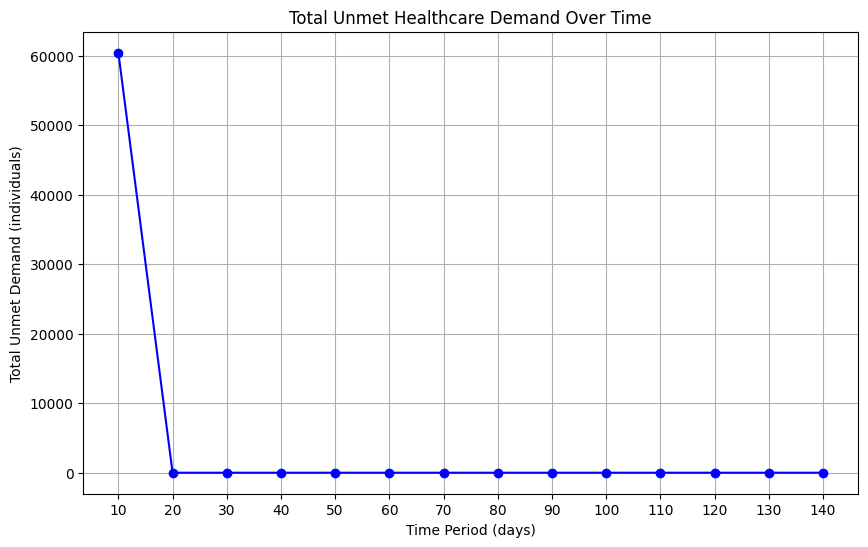

SIRV proportions data saved to 'basicModelOutputData\sirvProportions.csv'
SIRV proportions plot saved to 'basicModelOutputData\sirvProportions.png'


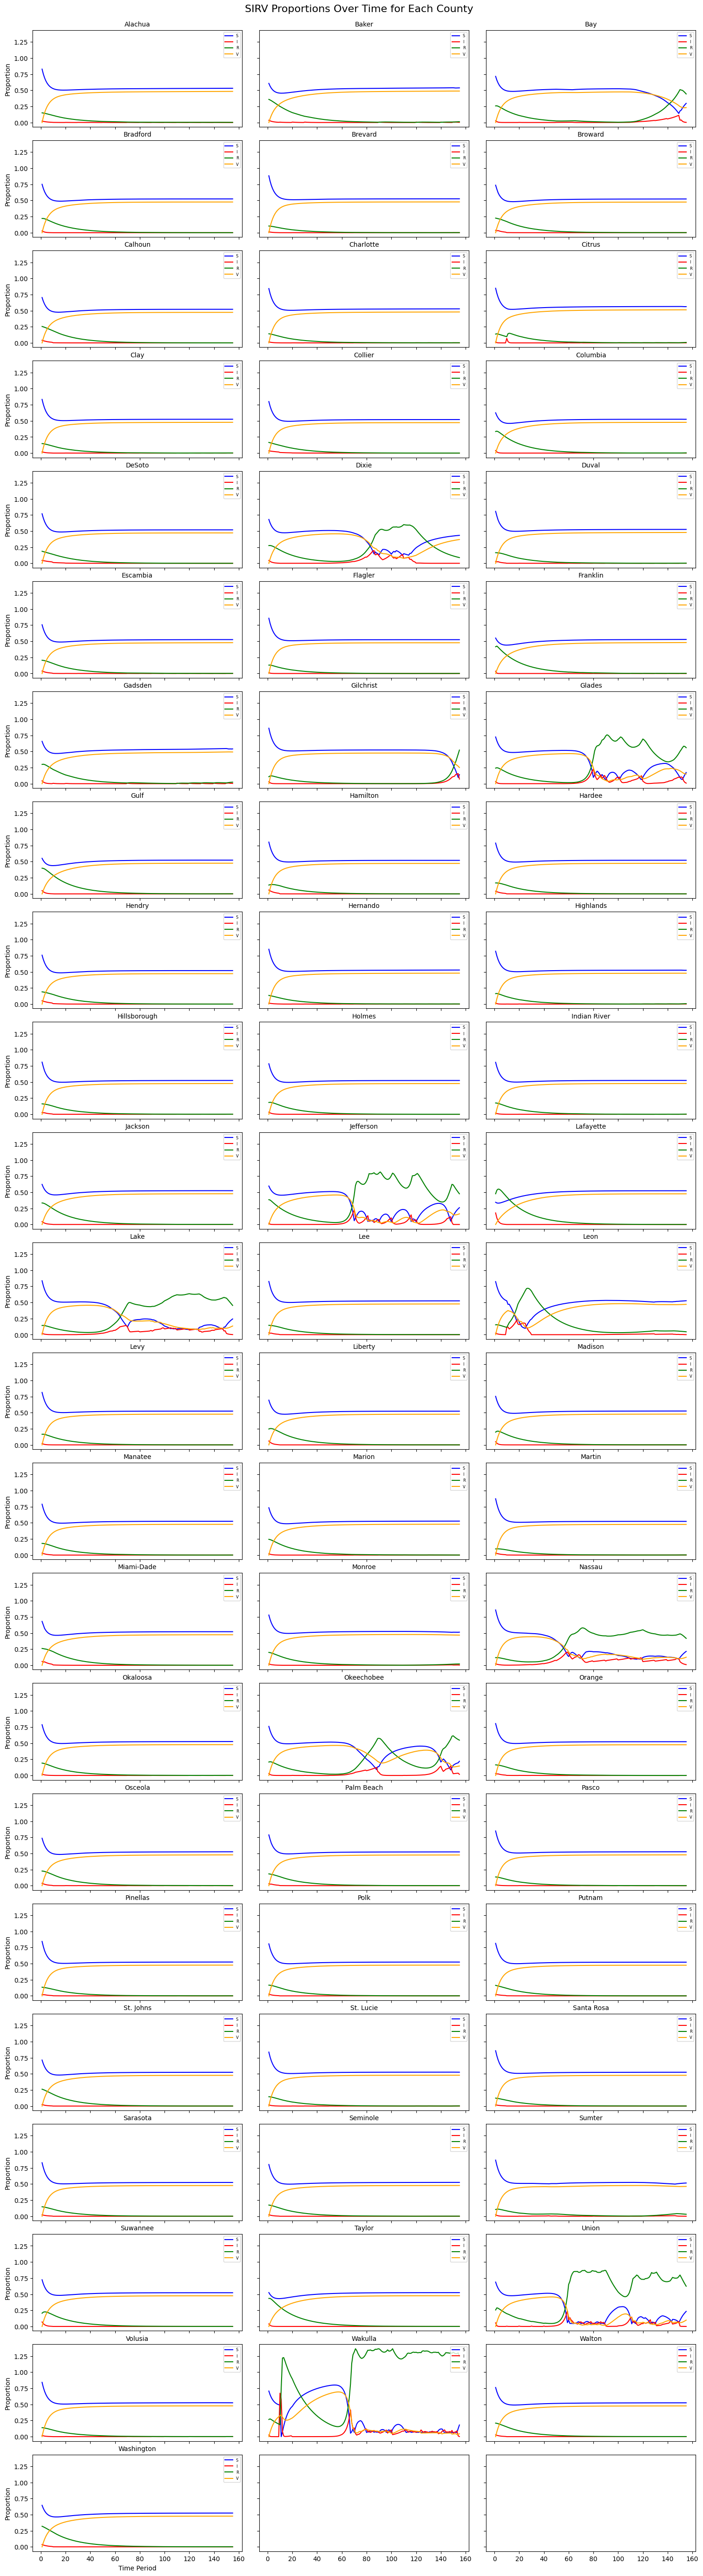

In [ ]:
print(U)
output_folder = "basicModelOutputData"
#save_decision_variables(Z, A, S, I, R, V, U, output_folder, tSet, range(min(tSet), max(tSet), q), iSet)
plot_unmet_demand(U, range(min(kSet), max(kSet), q), iSet)#
save_and_plot_sirv_proportions(S, I, R, V, N, iSet, tSet, output_folder)

